In [1]:
import sys
sys.path.insert(1, '/home/msantola/MyPythonLibrary/AnalysisObservations/libobs/')
import climbasis as climb
from climbasis import *
import domain as dom
import myplot
import numpy.ma as ma
from myplot import *
import obsinfo as obs
from obsinfo import *


In [2]:
##13 - 15 October 2013 (Tropical Cyclone Phailin) -> 85 mm at Pyramid
#13 - 15 October 2014 (Tropical Cyclone Hudhud) -> 39 mm at Pyramid
#18-19 October 2021 -> 65 mm at Phorste; 36 mm at Base camp
#4 October 2025 -> 100 mm at Pyramid; 130 mm at Base camp


In [3]:
year=2021;month=10
sourceData=f'/bdd/ERA5/NETCDF/GLOBAL_025/4xdaily/AN_PL/{year}/'

In [4]:
#cc.201410.aphe5.GLOBAL_025.nc	 d.201410.aphe5.GLOBAL_025.nc	u.201410.aph2e5.GLOBAL_025.nc  v.201410.aphe5.GLOBAL_025.nc
#ciwc.201410.aphe5.GLOBAL_025.nc  r.201410.aph2e5.GLOBAL_025.nc	u.201410.aphe5.GLOBAL_025.nc   vo.201410.aphe5.GLOBAL_025.nc
#clwc.201410.aphe5.GLOBAL_025.nc  r.201410.aphe5.GLOBAL_025.nc	v.201410.aph2e5.GLOBAL_025.nc  w.201410.aphe5.GLOBAL_025.nc


In [5]:
u2=xr.open_dataset(sourceData +f'u.{year}{month}.aph2e5.GLOBAL_025.nc')
uLevs=xr.open_dataset(sourceData +f'u.{year}{month}.aphe5.GLOBAL_025.nc')
vLevs=xr.open_dataset(sourceData +f'v.{year}{month}.aphe5.GLOBAL_025.nc')

##ncatted -a history,global,d,, /scratch/ms/fr/lmi/ERA5/AN_PL/2014/u.201410.aphe5.GLOBAL_025.nc >>use this one as w is only like tis
#ncatted -a history,global,d,, /scratch/ms/fr/lmm/ERA5/AN_PL/2014/u.201410.aph2e5.GLOBAL_025.nc

In [10]:
#ccLevs=xr.open_dataset(sourceData +f'cc.{year}{month}.aphe5.GLOBAL_025.nc')
ccLevs=xr.open_dataset(f'/bdd/CHIRPSv2/p05/chirps-v2.0.{year}.days_p05.nc')
#ccLevs

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, time: 365)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2022-01-18
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [11]:
lev0=850
#t=ccLevs.sel(level=lev0)['cc']
t=ccLevs['precip']
u=uLevs.sel(level=lev0)['u']
v=vLevs.sel(level=lev0)['v']

In [13]:
t

<xarray.DataArray 'precip' (time: 365, latitude: 2000, longitude: 7200)>
[5256000000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [14]:
#season = 'DJF'
day=18
# Select the season
t_event= t.sel(time=f'{year}-{month}-{day}')#.mean('time')
u_event = u.sel(time=f'{year}-{month}-{day}').mean('time')
v_event = v.sel(time=f'{year}-{month}-{day}').mean('time')


In [15]:

latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain('MA')
print(latS,latN,lonW,lonE)

10 60 40 130


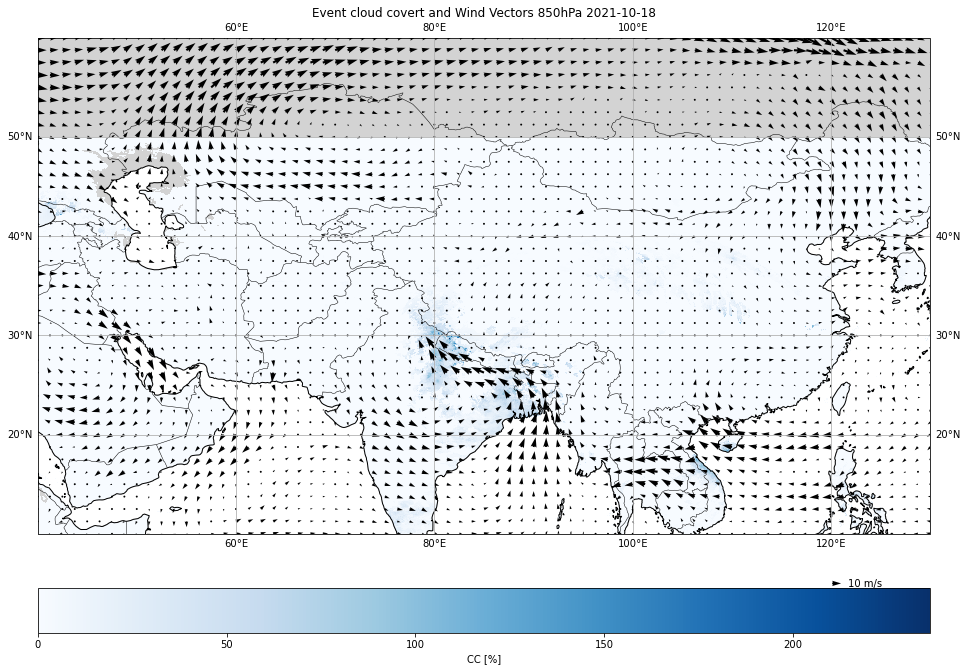

In [16]:

proj = ccrs.PlateCarree()

# Create figure
fig, ax = plt.subplots(figsize=(16,20), subplot_kw={'projection': proj})

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot temperature climatology (shading)
c = ax.pcolormesh(
     t_event.longitude, t_event.latitude, t_event,
    cmap='Blues', shading='auto', transform=ccrs.PlateCarree()
)
cb = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Precip [mm]')
ax.set_extent([lonW,lonE,latS,latN], crs=ccrs.PlateCarree())

# Plot wind vectors (thin out for clarity)
skip = 5 # adjust this to reduce arrow density
Q=ax.quiver(
    u_event.longitude[::skip], u_event.latitude[::skip],
    u_event[::skip, ::skip], v_event[::skip, ::skip],
    transform=ccrs.PlateCarree(), scale=1000
)
ax.quiverkey(
    Q,
    X=0.9, Y=-0.1,  # position in axes coordinates
    U=10,  # reference vector length in m/s
    label='10 m/s',
    labelpos='E')

# Optional: Add gridlines and title
ax.gridlines(draw_labels=True)
ax.set_title(f'Event cloud covert and Wind Vectors {lev0}hPa {year}-{month}-{day}')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# List of days you want to plot
days = [17, 18, 19, 20]

proj = ccrs.PlateCarree()

# Create figure and axes (2x2 grid)
fig, axes = plt.subplots(
    2, 2, figsize=(16, 16),
    subplot_kw={'projection': proj}
)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, day in enumerate(days):
    ax = axes[i]

    # Select data for this day
    t_event = t.sel(time=f'{year}-{month}-{day}')#.mean('time')
    u_event = u.sel(time=f'{year}-{month}-{day}').mean('time')
    v_event = v.sel(time=f'{year}-{month}-{day}').mean('time')

    # Map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())

    # Shaded temperature (or cloud cover)
    c = ax.pcolormesh(
        t_event.longitude, t_event.latitude, t_event,
        cmap='Blues', shading='auto', transform=ccrs.PlateCarree()
    )

    # Wind vectors (thinned for clarity)
    skip = 5
    Q = ax.quiver(
        u_event.longitude[::skip], u_event.latitude[::skip],
        u_event[::skip, ::skip], v_event[::skip, ::skip],
        transform=ccrs.PlateCarree(), scale=1000
    )

    # Add quiver key only once (e.g., bottom-right panel)
    if i == 3:
        ax.quiverkey(Q, X=0.9, Y=-0.1, U=10, label='10 m/s', labelpos='E')

    # Gridlines and title
    gl = ax.gridlines(draw_labels=True, linewidth=0.2)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f'{year}-{month}-{day}', fontsize=12)

# Adjust layout and add a single colorbar
fig.subplots_adjust(bottom=0.2, top=0.8, wspace=0.015, hspace=0.025)
cbar_ax = fig.add_axes([0.25, 0.06, 0.5, 0.02])  # x0, y0, width, height
cb = fig.colorbar(c, cax=cbar_ax, orientation='horizontal')
cb.set_label('Precip chirps [mm/day]')

fig.suptitle(f'Event Cloud Cover and Wind Vectors {lev0}hPa ({year}-{month})', y=0.8,fontsize=16)
plt.show()


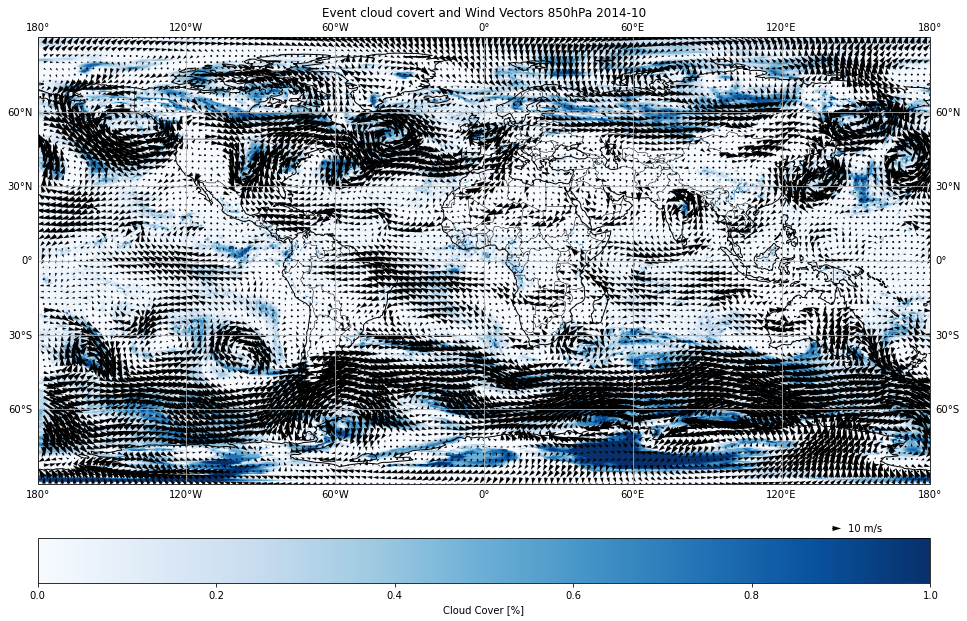

In [41]:

proj = ccrs.PlateCarree()

# Create figure
fig, ax = plt.subplots(figsize=(16,20), subplot_kw={'projection': proj})

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot temperature climatology (shading)
c = ax.pcolormesh(
    t_event.longitude, t_event.latitude, t_event,
    cmap='Blues', shading='auto', transform=ccrs.PlateCarree()
)
cb = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Cloud Cover [%]')
#ax.set_extent([-15, 30, 30, 70], crs=ccrs.PlateCarree())

# Plot wind vectors (thin out for clarity)
skip = 10 # adjust this to reduce arrow density
Q=ax.quiver(
    u_event.longitude[::skip], u_event.latitude[::skip],
    u_event[::skip, ::skip], v_event[::skip, ::skip],
    transform=ccrs.PlateCarree(), scale=1000
)
ax.quiverkey(
    Q,
    X=0.9, Y=-0.1,  # position in axes coordinates
    U=10,  # reference vector length in m/s
    label='10 m/s',
    labelpos='E')

# Optional: Add gridlines and title
ax.gridlines(draw_labels=True)
ax.set_title(f'Event cloud covert and Wind Vectors {lev0}hPa {year}-{month}')

plt.show()
